In [ ]:
!pip install open_clip_torch chromadb matplotlib tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manyli

In [ ]:
import torch
import numpy as np
from keras.datasets import cifar10
from PIL import Image

# Tải tập dữ liệu CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Chuyển đổi dữ liệu thành các đối tượng PIL Image
x_train = [Image.fromarray(img) for img in x_train]
x_test = [Image.fromarray(img) for img in x_test]

# Lấy tên các lớp từ tập dữ liệu
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step


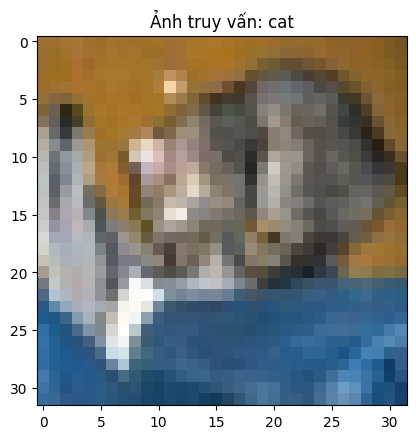

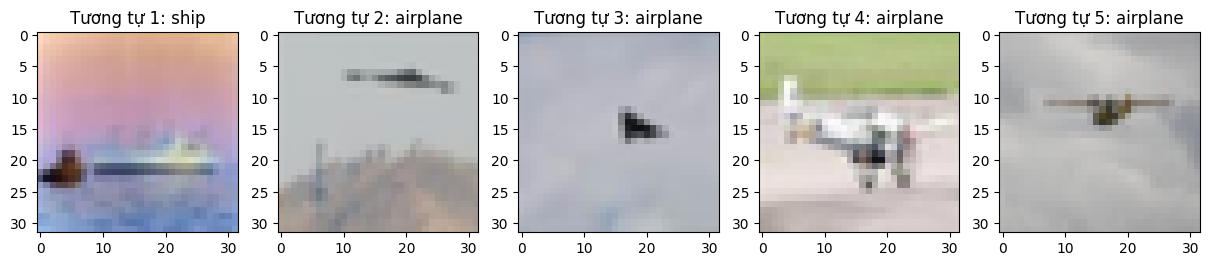

In [ ]:
import matplotlib.pyplot as plt

# Chọn một ảnh truy vấn từ tập kiểm tra
query_image_index = 0  # Bạn có thể thay đổi chỉ số này để chọn ảnh khác
query_image = x_test[query_image_index]
query_label = y_test[query_image_index][0]

# Hiển thị ảnh truy vấn và nhãn tương ứng
plt.imshow(query_image)
plt.title(f"Ảnh truy vấn: {class_names[query_label]}")
plt.show()

# Tính toán khoảng cách L2 giữa ảnh truy vấn và các ảnh trong tập huấn luyện
query_image_np = np.array(query_image).flatten()
x_train_np = np.array([np.array(img).flatten() for img in x_train])

distances = np.linalg.norm(x_train_np - query_image_np, axis=1)

# Tìm 5 ảnh tương tự nhất
k = 5
top_k_indices = np.argsort(distances)[:k]

# Hiển thị các ảnh tương tự tìm được
fig, axes = plt.subplots(1, k, figsize=(15, 3))
for i, index in enumerate(top_k_indices):
    axes[i].imshow(x_train[index])
    axes[i].set_title(f"Tương tự {i + 1}: {class_names[y_train[index][0]]}")
plt.show()


In [ ]:
!pip install git+https://github.com/openai/CLIP.git

import clip
import torch
from tqdm import tqdm

# Tải mô hình CLIP đã được huấn luyện trước
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Tiền xử lý và trích xuất đặc trưng cho ảnh truy vấn
query_image_preprocessed = preprocess(query_image).unsqueeze(0).to(device)
with torch.no_grad():
    query_image_features = model.encode_image(query_image_preprocessed)
query_image_features = query_image_features.cpu().numpy()

# Tiền xử lý và trích xuất đặc trưng cho các ảnh trong tập huấn luyện
train_image_features = []
for img in tqdm(x_train, desc="Trích xuất đặc trưng"):
    img_preprocessed = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        img_features = model.encode_image(img_preprocessed)
    train_image_features.append(img_features.cpu().numpy())
train_image_features = np.vstack(train_image_features)

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-n5x3gmej
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-n5x3gmej
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=46e704066e485139cf0fd9380a57fc7748f6c02f929472452b344a1d0278abf5
  Stored in directory: /tmp/pip-ephem-wheel-cache-k4qw8fg1/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 114MiB/s]
Trích xuất đặc trưng: 100%|██████████| 50000/50000 [08:33<00:00, 97.43it/s]


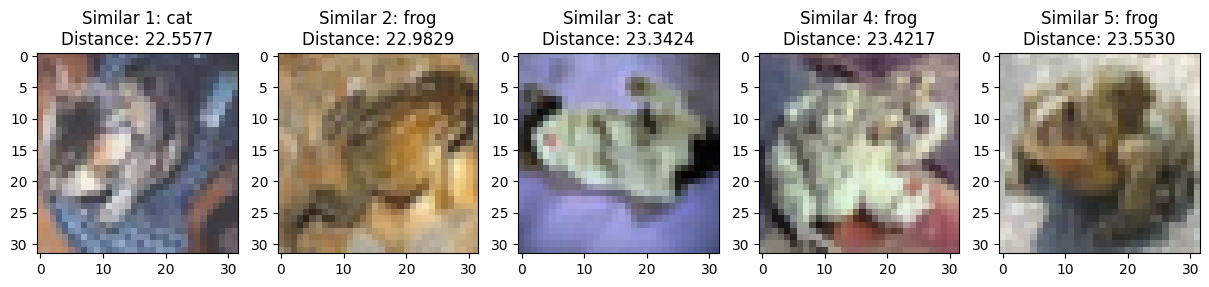

In [ ]:
# Initialize ChromaDB client
import chromadb
from chromadb.config import Settings
client = chromadb.Client()

# Create a collection
collection = client.create_collection("image_collection")

# Split data into smaller batches to fit ChromaDB's constraints
batch_size = 10000
num_batches = int(np.ceil(len(train_image_features) / batch_size))

for i in range(num_batches):
    start_index = i * batch_size
    end_index = min((i + 1) * batch_size, len(train_image_features))
    embeddings_batch = train_image_features[start_index:end_index].tolist()
    metadatas_batch = [{"label": class_names[label[0]]} for label in y_train[start_index:end_index]]
    ids_batch = [str(j) for j in range(start_index, end_index)]

    collection.add(
        embeddings=embeddings_batch,
        metadatas=metadatas_batch,
        ids=ids_batch
    )

# Perform image query
results = collection.query(
    query_embeddings=query_image_features.flatten().tolist(),
    n_results=5
)

# Display the most similar images found in the query
k = 5
fig, axes = plt.subplots(1, k, figsize=(15, 3))
for i, (id, distance, metadata) in enumerate(zip(results['ids'][0], results['distances'][0], results['metadatas'][0])):
    image_index = int(id)
    axes[i].imshow(x_train[image_index])
    axes[i].set_title(f"Similar {i + 1}: {metadata['label']}\nDistance: {distance:.4f}")
plt.show()

In [ ]:
def search_by_text(text_query, model, preprocess, collection, x_train, class_names, k=5):
    # Mã hóa văn bản truy vấn
    text_input = clip.tokenize([text_query]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_input)
    text_features = text_features.cpu().numpy()

    # Thực hiện truy vấn
    results = collection.query(
        query_embeddings=text_features.flatten().tolist(),
        n_results=k
    )

    # Hiển thị kết quả
    fig, axes = plt.subplots(1, k, figsize=(15, 3))
    for i, (id, distance, metadata) in enumerate(zip(results['ids'][0], results['distances'][0], results['metadatas'][0])):
        image_index = int(id)
        axes[i].imshow(x_train[image_index])
        axes[i].set_title(f"Similar {i + 1}: {metadata['label']}\nDistance: {distance:.4f}")
    plt.show()

In [ ]:
def search_by_image(image_path, model, preprocess, collection, x_train, class_names, k=5):
    # Đọc và tiền xử lý ảnh đầu vào
    query_image = Image.open(image_path)
    query_image_preprocessed = preprocess(query_image).unsqueeze(0).to(device)

    # Trích xuất đặc trưng của ảnh
    with torch.no_grad():
        query_image_features = model.encode_image(query_image_preprocessed)
    query_image_features = query_image_features.cpu().numpy()

    # Thực hiện truy vấn
    results = collection.query(
        query_embeddings=query_image_features.flatten().tolist(),
        n_results=k
    )

    # Hiển thị kết quả
    fig, axes = plt.subplots(1, k+1, figsize=(18, 3))
    axes[0].imshow(query_image)
    axes[0].set_title("Query Image")
    for i, (id, distance, metadata) in enumerate(zip(results['ids'][0], results['distances'][0], results['metadatas'][0])):
        image_index = int(id)
        axes[i+1].imshow(x_train[image_index])
        axes[i+1].set_title(f"Similar {i + 1}: {metadata['label']}\nDistance: {distance:.4f}")
    plt.show()

In [ ]:
import ipywidgets as widgets
from IPython.display import display

def create_interface(model, preprocess, collection, x_train, class_names):
    text_input = widgets.Text(description="Text Query:")
    text_button = widgets.Button(description="Search by Text")
    file_upload = widgets.FileUpload(description="Upload Image")
    image_button = widgets.Button(description="Search by Image")

    output = widgets.Output()

    def on_text_button_clicked(b):
        with output:
            output.clear_output()
            search_by_text(text_input.value, model, preprocess, collection, x_train, class_names)

    def on_image_button_clicked(b):
        with output:
            output.clear_output()
            if file_upload.value:
                file_content = next(iter(file_upload.value.values()))['content']
                with open('temp_image.jpg', 'wb') as f:
                    f.write(file_content)
                search_by_image('temp_image.jpg', model, preprocess, collection, x_train, class_names)
            else:
                print("Please upload an image first.")

    text_button.on_click(on_text_button_clicked)
    image_button.on_click(on_image_button_clicked)

    display(widgets.VBox([text_input, text_button, file_upload, image_button, output]))

In [ ]:
# Sau khi đã tạo model, preprocess, collection, và chuẩn bị dữ liệu
create_interface(model, preprocess, collection, x_train, class_names)